In [0]:
import pandas as pd
import numpy as np
import pylab
import datetime
import time
from matplotlib import pyplot as plt
from skimage.io import imread
from skimage import img_as_float
from sklearn import datasets
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn import preprocessing as prep
from sklearn.preprocessing import StandardScaler
from sklearn import utils
from sklearn import svm
from sklearn.model_selection import GridSearchCV
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
from sklearn.metrics import r2_score, make_scorer
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

%matplotlib inline

#Подход 1: градиентный бустинг "в лоб"
Один из самых универсальных алгоритмов, изученных в нашем курсе, является градиентный бустинг. Он не очень требователен к данным, восстанавливает нелинейные зависимости, и хорошо работает на многих наборах данных, что и обуславливает его популярность. Вполне разумной мыслью будет попробовать именно его в первую очередь.

####1.Считайте таблицу с признаками из файла features.csv.


In [0]:
dataset_filepath = '/content/drive/My Drive/coursera/Week 7/week_7_features.zip'
data_train = pd.read_csv(dataset_filepath, index_col="match_id")
data_train.head()

,start_time,lobby_type,r1_hero,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,r1_items,r2_hero,r2_level,r2_xp,r2_gold,r2_lh,r2_kills,r2_deaths,r2_items,r3_hero,r3_level,r3_xp,r3_gold,r3_lh,r3_kills,r3_deaths,r3_items,r4_hero,r4_level,r4_xp,r4_gold,r4_lh,r4_kills,r4_deaths,r4_items,r5_hero,r5_level,r5_xp,r5_gold,r5_lh,r5_kills,...,d4_xp,d4_gold,d4_lh,d4_kills,d4_deaths,d4_items,d5_hero,d5_level,d5_xp,d5_gold,d5_lh,d5_kills,d5_deaths,d5_items,first_blood_time,first_blood_team,first_blood_player1,first_blood_player2,radiant_bottle_time,radiant_courier_time,radiant_flying_courier_time,radiant_tpscroll_count,radiant_boots_count,radiant_ward_observer_count,radiant_ward_sentry_count,radiant_first_ward_time,dire_bottle_time,dire_courier_time,dire_flying_courier_time,dire_tpscroll_count,dire_boots_count,dire_ward_observer_count,dire_ward_sentry_count,dire_first_ward_time,duration,radiant_win,tower_status_radiant,tower_status_dire,barracks_status_radiant,barracks_status_dire
match_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1430198770,7,11,5,2098,1489,20,0,0,7,67,3,842,991,10,0,0,4,29,5,1909,1143,10,0,0,8,20,3,757,741,6,0,0,7,105,3,732,658,4,0,...,742,500,2,0,0,8,84,3,958,1003,3,1,0,9,7.0,1.0,9.0,NaN,134.0,-80.0,244.0,2,2,2,0,35.0,103.0,-84.0,221.0,3,4,2,2,-52.0,2874,1,1796,0,51,0
1,1430220345,0,42,4,1188,1033,9,0,1,12,49,4,1596,993,10,0,1,7,67,4,1506,1502,18,1,0,7,37,3,669,631,7,0,0,7,26,2,415,539,1,0,...,440,583,0,0,0,7,12,4,1470,1622,24,0,0,9,54.0,1.0,7.0,NaN,173.0,-80.0,NaN,2,0,2,0,-20.0,149.0,-84.0,195.0,5,4,3,1,-5.0,2463,1,1974,0,63,1
2,1430227081,7,33,4,1319,1270,22,0,0,12,98,3,1314,775,6,0,0,6,20,3,1297,909,0,1,0,6,27,5,2360,2096,26,1,1,6,4,3,1395,1627,27,0,...,1319,667,4,0,0,7,80,3,1350,1512,25,0,0,7,224.0,0.0,3.0,NaN,63.0,-82.0,NaN,2,5,2,1,-39.0,45.0,-77.0,221.0,3,4,3,1,13.0,2130,0,0,1830,0,63
3,1430263531,1,29,4,1779,1056,14,0,0,5,30,2,539,539,1,0,0,6,75,5,2037,1139,15,0,0,6,37,2,591,499,0,0,0,6,41,3,712,1075,12,0,...,674,537,1,0,0,7,20,2,510,499,0,0,0,7,NaN,NaN,NaN,NaN,208.0,-75.0,NaN,0,3,2,0,-30.0,124.0,-80.0,184.0,0,4,2,0,27.0,1459,0,1920,2047,50,63
4,1430282290,7,13,4,1431,1090,8,1,0,8,27,2,629,552,0,0,1,7,30,3,884,927,0,1,0,8,72,3,925,1439,16,1,0,11,93,4,1482,880,7,0,...,1815,1275,18,0,0,8,8,4,1119,904,6,0,1,7,-21.0,1.0,6.0,NaN,166.0,-81.0,181.0,1,4,2,0,46.0,182.0,-80.0,225.0,6,3,3,0,-16.0,2449,0,4,1974,3,63


#### Удалите признаки, связанные с итогами матча (они помечены в описании данных как отсутствующие в тестовой выборке).

In [0]:
data_train.drop(["duration", "tower_status_radiant", "tower_status_dire", "barracks_status_radiant", "barracks_status_dire",], axis=1, inplace=True)

In [0]:
data_train.shape

(97230, 103)

####2.Проверьте выборку на наличие пропусков с помощью функции count(), которая для каждого столбца показывает число заполненных значений. Много ли пропусков в данных? Запишите названия признаков, имеющих пропуски, и попробуйте для любых двух из них дать обоснование, почему их значения могут быть пропущены.


In [0]:
na_total = len(data_train) - data_train.count()

(na_total[na_total>0]/len(data_train)*100).sort_values(ascending=False)

first_blood_player2            45.240152
radiant_flying_courier_time    28.261853
dire_flying_courier_time       26.841510
first_blood_player1            20.110048
first_blood_team               20.110048
first_blood_time               20.110048
dire_bottle_time               16.602900
radiant_bottle_time            16.138023
radiant_first_ward_time         1.888306
dire_first_ward_time            1.878021
radiant_courier_time            0.711714
dire_courier_time               0.695259
dtype: float64

##**Обоснование пропусков в данных**

Признаки которые имеют пропуски (доля в % от всего столбца) в данном датасете двух типов:

"first_blood"-type
* first_blood_player2            45.24%
* first_blood_player1            20.11%
* first_blood_team               20.11%
* first_blood_time               20.11%


"bottle/ward/courier"-type
* radiant_flying_courier_time    28.26%
* dire_flying_courier_time       26.84%
* dire_bottle_time               16.60%
* radiant_bottle_time            16.13%
* radiant_first_ward_time         1.88%
* dire_first_ward_time            1.87%
* radiant_courier_time            0.71%
* dire_courier_time               0.69%

Это все признаки - могут не иметь начального значения поскольку, не в каждом матче игроки обеих команд успевают купить тот или иной предмет (bottle, courier, ward) за первые 5 минут игрового времени, а также не всегда происходит "первая кровь" - убийство вражеского героя.

####3.Замените пропуски на нули с помощью функции fillna(). На самом деле этот способ является предпочтительным для логистической регрессии, поскольку он позволит пропущенному значению не вносить никакого вклада в предсказание. Для деревьев часто лучшим вариантом оказывается замена пропуска на очень большое или очень маленькое значение — в этом случае при построении разбиения вершины можно будет отправить объекты с пропусками в отдельную ветвь дерева. Также есть и другие подходы — например, замена пропуска на среднее значение признака. Мы не требуем этого в задании, но при желании попробуйте разные подходы к обработке пропусков и сравните их между собой.



In [0]:
data_train.fillna(0, inplace=True)


4.Какой столбец содержит целевую переменную? Запишите его название.


In [0]:
X_train = data_train.drop("radiant_win", axis=1)
y_train = data_train["radiant_win"]

####Столбец целевой переменной - "radiant_win"


####5.Забудем, что в выборке есть категориальные признаки, и попробуем обучить градиентный бустинг над деревьями на имеющейся матрице "объекты-признаки". Зафиксируйте генератор разбиений для кросс-валидации по 5 блокам (KFold), не забудьте перемешать при этом выборку (shuffle=True), поскольку данные в таблице отсортированы по времени, и без перемешивания можно столкнуться с нежелательными эффектами при оценивании качества. Оцените качество градиентного бустинга (GradientBoostingClassifier) с помощью данной кросс-валидации, попробуйте при этом разное количество деревьев (как минимум протестируйте следующие значения для количества деревьев: 10, 20, 30).



In [0]:
# preserve KFold generator
cross_val_folds = KFold(n_splits=5, shuffle=True, random_state=42)

In [0]:
def get_train_cross_val_score_clf_parametric(classifier, k_folds, parameter_name:str, parameter_values:list, scoring_function_text:str, **kwargs)->():
    scores = {} if 'scores' not in dir() else scores
    times = {}
    params = {}
    params.update(kwargs)
    print("*"*133)
    print("pre-testing defined parameters were", kwargs)
    print(f"hyper-tuning '{str(classifier).split('.')[-1][:-2]}' classifier using '{scoring_function_text}' scoring function")
    print(f"parameter name to tune '{parameter_name}', cycle through values:", parameter_values)
    print("*"*133)
    for test_value in parameter_values:
        _cycle_start_time = time.time()
        params[parameter_name] = test_value
        clf  = classifier(**params)
        clf.fit(X_train, y_train)
        scores[test_value] = np.mean(cross_val_score(clf, X_train, y_train, cv=k_folds, scoring=scoring_function_text, n_jobs=-1))
        times[test_value] = time.time() - _cycle_start_time
        print(f"{parameter_name} = {test_value} using {scoring_function_text} score is {scores[test_value]:.7f}, "+
              f"this run took {times[test_value]:.2f} seconds, done {list(parameter_values).index(test_value)+1} of {len(parameter_values)}")

    return scores, times

def print_best_score(scores: {}) -> ():
    scores_df = pd.DataFrame([scores]).T
    max_score_value = scores_df.max()[0]
    max_score_index = scores_df.idxmax()[0]
    print(f"Maximum value of {max_score_value} reached with {max_score_index} value of the parameter")
    #return (max_score_index, max_score_value)

def plot_scores(scores: {}, title="just another graph") -> ():
    plt.figure(figsize=(14,7))
    scores_df = pd.DataFrame([scores]).T
    plt.title(title)
    plt.plot(scores_df)

In [0]:
# main GBoost run
from itertools import chain
clf_params = {"random_state": 42}
n_estimators_test_values = list(chain(range(10,101,10), range(150,301,50)))
scores, times = get_train_cross_val_score_clf_parametric(GradientBoostingClassifier, cross_val_folds, "n_estimators", n_estimators_test_values, "roc_auc", **clf_params)

n_estimators = 10 using roc_auc score is 0.6648507, this run took 63.80 seconds

n_estimators = 20 using roc_auc score is 0.6824619, this run took 126.97 seconds

n_estimators = 30 using roc_auc score is 0.6900065, this run took 193.26 seconds

n_estimators = 40 using roc_auc score is 0.6940387, this run took 254.86 seconds

n_estimators = 50 using roc_auc score is 0.6974944, this run took 320.43 seconds

n_estimators = 60 using roc_auc score is 0.7001193, this run took 384.07 seconds

n_estimators = 70 using roc_auc score is 0.7021165, this run took 445.91 seconds

n_estimators = 80 using roc_auc score is 0.7038157, this run took 508.58 seconds

n_estimators = 90 using roc_auc score is 0.7051577, this run took 572.26 seconds

n_estimators = 100 using roc_auc score is 0.7062230, this run took 637.17 seconds

n_estimators = 150 using roc_auc score is 0.7103702, this run took 783.06 seconds

n_estimators = 200 using roc_auc score is 0.7137062, this run took 1046.10 seconds

n_estimators = 250 using roc_auc score is 0.7158875, this run took 1304.28 seconds

n_estimators = 300 using roc_auc score is 0.7174401, this run took 1566.90 seconds

In [0]:
print_best_score(scores)

Maximum value of 0.7174401 reached with 300 value of the parameter


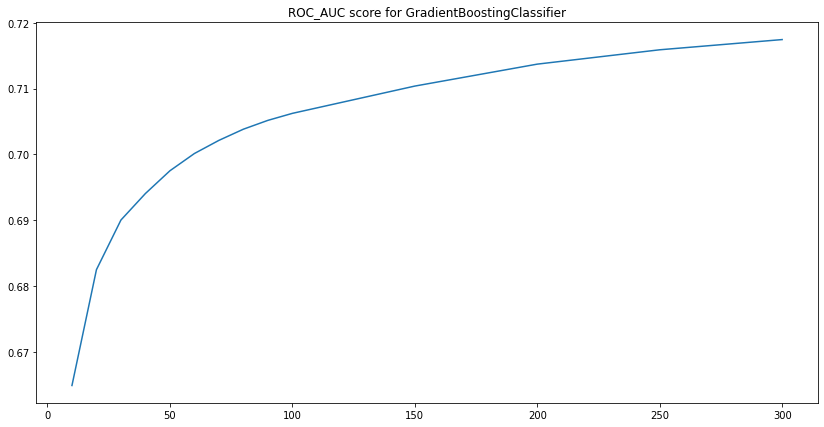

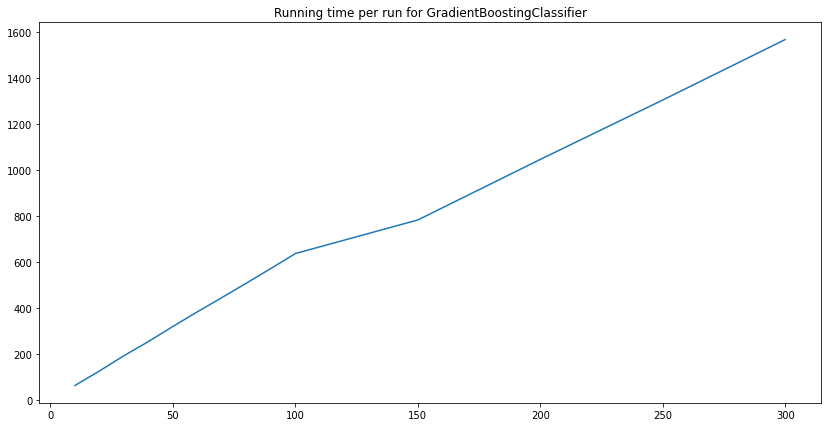

In [0]:
plot_scores(scores, "ROC_AUC score for GradientBoostingClassifier")
plot_scores(times, "Running time per run for GradientBoostingClassifier")

#### Долго ли настраивались классификаторы? Достигнут ли оптимум на испытанных значениях параметра n_estimators, или же качество, скорее всего, продолжит расти при дальнейшем его увеличении?

Как можно видеть из графиков - градиентный бустинг "в лоб" достигает максимального качества (ROC_AUC) в 0.7174401 при параметре n_estimators - 300. Но при этом на настройку такого классификатора уходит чуть более 26 минут (для сравнения при параметре 10 - качество хуже 0.6648507, но нужно всего 63 секунды для настройки модели).
Рост качества продолжает расти с ростом количества деревьев (n_estimators), но уже намного медленнее.


#Подход 2: логистическая регрессия


1. Оцените качество логистической регрессии (sklearn.linear_model.LogisticRegression с L2-регуляризацией) с помощью кросс-валидации по той же схеме, которая использовалась для градиентного бустинга.

In [0]:
data_scaler = StandardScaler()
X_train = pd.DataFrame(data_scaler.fit_transform(X_train), index=X_train.index, columns=X_train.columns)
X_train.head()

,start_time,lobby_type,r1_hero,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,r1_items,r2_hero,r2_level,r2_xp,r2_gold,r2_lh,r2_kills,r2_deaths,r2_items,r3_hero,r3_level,r3_xp,r3_gold,r3_lh,r3_kills,r3_deaths,r3_items,r4_hero,r4_level,r4_xp,r4_gold,r4_lh,r4_kills,r4_deaths,r4_items,r5_hero,r5_level,r5_xp,r5_gold,r5_lh,r5_kills,...,d3_lh,d3_kills,d3_deaths,d3_items,d4_hero,d4_level,d4_xp,d4_gold,d4_lh,d4_kills,d4_deaths,d4_items,d5_hero,d5_level,d5_xp,d5_gold,d5_lh,d5_kills,d5_deaths,d5_items,first_blood_time,first_blood_team,first_blood_player1,first_blood_player2,radiant_bottle_time,radiant_courier_time,radiant_flying_courier_time,radiant_tpscroll_count,radiant_boots_count,radiant_ward_observer_count,radiant_ward_sentry_count,radiant_first_ward_time,dire_bottle_time,dire_courier_time,dire_flying_courier_time,dire_tpscroll_count,dire_boots_count,dire_ward_observer_count,dire_ward_sentry_count,dire_first_ward_time
match_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,-2.544364,1.540688,-1.244228,1.400808,1.525972,0.734957,0.969743,-0.537757,-0.578083,-0.509023,0.453467,-0.332256,-0.625222,-0.255162,-0.052580,-0.533149,-0.582396,-1.756715,-0.728192,1.50723,1.308568,0.095346,-0.037204,-0.529081,-0.578154,-0.112095,-0.999319,-0.282744,-0.729830,-0.757388,-0.446505,-0.525343,-0.579877,-0.525183,1.606179,-0.277630,-0.771379,-0.935772,-0.669994,-0.524078,...,1.416964,-0.538253,-0.571065,-0.947053,-0.490513,-0.311205,-0.785580,-1.312874,-0.905651,-0.53886,-0.56754,-0.131690,0.950987,-0.316231,-0.398260,-0.192406,-0.794164,0.976866,-0.565289,0.278256,-0.849902,1.182703,1.681514,-0.788219,0.378538,-0.029781,0.876751,-0.514555,-1.136970,-0.532046,-0.987486,1.066448,-0.041743,-0.262922,0.640648,0.018054,0.562864,-0.551154,1.846004,-1.121494
1,-2.540452,-0.927798,-0.292258,0.501314,-0.080139,-0.247570,-0.246859,-0.537757,1.017574,1.492930,-0.097431,0.578881,0.732454,-0.250795,-0.052580,-0.533149,1.019572,-0.524101,0.438857,0.59158,0.582307,0.884835,0.856569,1.014674,-0.578154,-0.521910,-0.478969,-0.282744,-0.889558,-1.001642,-0.334372,-0.525343,-0.579877,-0.525183,-0.816535,-1.190175,-1.344598,-1.198371,-1.005251,-0.524078,...,-0.942193,2.506742,-0.571065,1.517711,-1.414707,-1.232681,-1.337375,-1.127777,-1.131068,-0.53886,-0.56754,-0.543653,-1.262018,0.599652,0.531154,1.183531,1.570177,-0.540155,-0.565289,0.278256,-0.287631,1.182703,1.050584,-0.788219,0.912215,-0.029781,-1.525446,-0.514555,-2.869460,-0.532046,-0.987486,-0.338591,0.578946,-0.262922,0.379585,1.066668,0.562864,0.678170,0.437788,0.043947
2,-2.539231,1.540688,-0.568637,0.501314,0.151070,0.263085,1.190944,-0.537757,-0.578083,1.492930,1.402237,-0.332256,0.224676,-0.726779,-0.498410,-0.533149,-0.582396,-0.934972,-1.004599,-0.32407,0.205660,-0.419251,-1.154419,1.014674,-0.578154,-0.931725,-0.785057,1.547927,2.179771,2.251377,1.796163,1.030097,1.043031,-0.937075,-1.491215,-0.277630,0.427498,1.202532,1.900308,-0.524078,...,-0.829853,-0.538253,-0.571065,-0.125465,-0.736965,0.610270,0.268676,-0.940451,-0.680234,-0.53886,-0.56754,-0.543653,0.828042,-0.316231,0.313323,0.939019,1.682765,-0.540155,-0.565289,-0.543829,1.746117,-0.845521,-0.211277,-0.788219,-0.593027,-0.146503,-1.525446,-0.514555,1.461765,-0.532046,0.391203,-0.823968,-0.824352,0.158654,0.640648,0.018054,0.562864,0.678170,0.437788,0.490286
3,-2.532622,-0.575157,-0.691471,0.501314,0.962950,-0.198013,0.306142,-0.537757,-0.578083,-1.309804,-0.678935,-1.243393,-1.170813,-1.242065,-1.055698,-0.533149,-0.582396,-0.934972,0.684551,1.50723,1.539241,0.086550,0.521404,-0.529081,-0.578154,-0.931725,-0.478969,-1.198079,-1.031136,-1.294746,-1.119305,-0.525343,-0.579877,-0.937075,-0.356526,-0.277630,-0.807544,-0.015573,0.224024,-0.524078,...,0.068874,-0.538253,-0.571065,-0.536259,1.511906,-1.232681,-0.909825,-1.230361,-1.018359,-0.53886,-0.56754,-0.543653,-1.016129,-1.232114,-1.211497,-1.312717,-1.131927,-0.540155,-0.565289,-0.543829,-0.933645,-0.845521,-1.157673,-0.788219,1.391156,0.262024,-1.525446,-

In [0]:
# main LogisticRegression run
clf_params = {"random_state": 42}
c_test_values = np.power(10.0, np.arange(-5, 6))
scores, times = get_train_cross_val_score_clf_parametric(LogisticRegression, cross_val_folds, "C", c_test_values, "roc_auc", **clf_params)

*************************************************************************************************************************************
pre-testing defined parameters were {'random_state': 42}
hyper-tuning 'LogisticRegression' classifier using 'roc_auc' scoring function
parameter name to tune 'C', cycle through values: [1.e-05 1.e-04 1.e-03 1.e-02 1.e-01 1.e+00 1.e+01 1.e+02 1.e+03 1.e+04
 1.e+05]
*************************************************************************************************************************************
C = 1e-05 using roc_auc score is 0.6951553, this run took 2.02 seconds, done 1 of 11
C = 0.0001 using roc_auc score is 0.7113524, this run took 2.46 seconds, done 2 of 11
C = 0.001 using roc_auc score is 0.7163631, this run took 4.40 seconds, done 3 of 11
C = 0.01 using roc_auc score is 0.7165499, this run took 6.39 seconds, done 4 of 11
C = 0.1 using roc_auc score is 0.7165269, this run took 6.58 seconds, done 5 of 11
C = 1.0 using roc_auc score is 0.7165221, th

Maximum value of 0.7165498862352037 reached with 0.01 value of the parameter


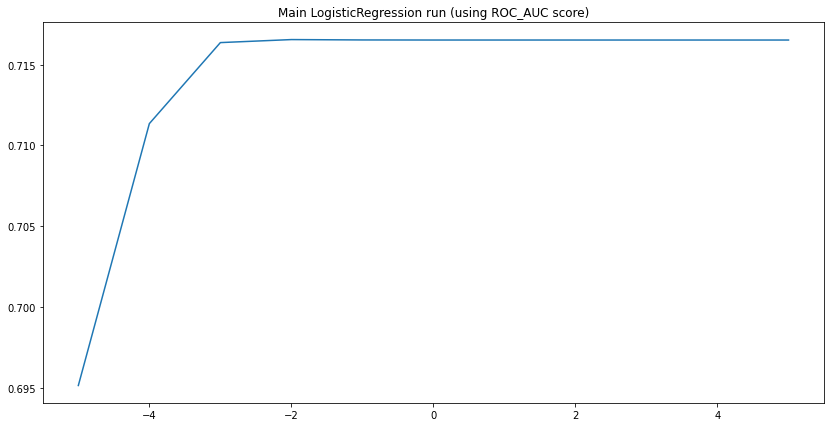

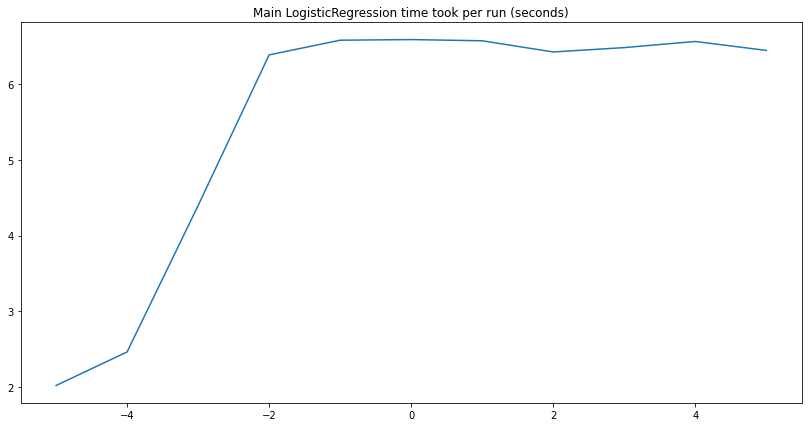

In [0]:
print_best_score(scores)
new_scores = pd.DataFrame([scores]).T
new_scores = new_scores.T.append(times,ignore_index=True)
new_scores.columns = np.arange(-5, 6)
plot_scores(new_scores.T.to_dict()[0], "Main LogisticRegression run (using ROC_AUC score)")
plot_scores(new_scores.T.to_dict()[1], "Main LogisticRegression time took per run (seconds)")

Достигнутое качество 0.7165498862352037 при параметре С=0.01 сравнимо с "лобовым" градиентным бустингом по 300 деревьям, НО при этом логистическая регрессия работает в десятки, а то и в сотни раз быстрее.
Также достигнутый результат говорит о том что характер зависимости между признаками и целевой переменной очень прямолинеен (бустинг может искать более сложные нелинейные зависимости, но здесь такого не произошло)


####2. Среди признаков в выборке есть категориальные, которые мы использовали как числовые, что вряд ли является хорошей идеей.


Категориальных признаков в этой задаче одиннадцать: lobby_type и r1_hero, r2_hero, ..., r5_hero, d1_hero, d2_hero, ..., d5_hero. Уберите их из выборки, и проведите кросс-валидацию для логистической регрессии на новой выборке с подбором лучшего параметра регуляризации. Изменилось ли качество? Чем вы можете это объяснить?

In [0]:
hero_columns = [f"{type}{number}_hero" for type in 'rd' for number in range(1, 6)]
categorial_columns = ["lobby_type"] + hero_columns
X_train.drop(categorial_columns, axis=1, inplace=True)

In [0]:
clf_params = {"random_state": 42}
c_test_values = np.power(10.0, np.arange(-5, 6))
scores, times = get_train_cross_val_score_clf_parametric(LogisticRegression, cross_val_folds, "C", c_test_values, "roc_auc", **clf_params)

*************************************************************************************************************************************
pre-testing defined parameters were {'random_state': 42}
hyper-tuning 'LogisticRegression' classifier using 'roc_auc' scoring function
parameter name to tune 'C', cycle through values: [1.e-05 1.e-04 1.e-03 1.e-02 1.e-01 1.e+00 1.e+01 1.e+02 1.e+03 1.e+04
 1.e+05]
*************************************************************************************************************************************
C = 1e-05 using roc_auc score is 0.6950921, this run took 3.27 seconds, done 1 of 11
C = 0.0001 using roc_auc score is 0.7113327, this run took 2.40 seconds, done 2 of 11
C = 0.001 using roc_auc score is 0.7163759, this run took 4.19 seconds, done 3 of 11
C = 0.01 using roc_auc score is 0.7165592, this run took 5.99 seconds, done 4 of 11
C = 0.1 using roc_auc score is 0.7165338, this run took 6.11 seconds, done 5 of 11
C = 1.0 using roc_auc score is 0.7165303, th

Maximum value of 0.7165592000076536 reached with 0.01 value of the parameter


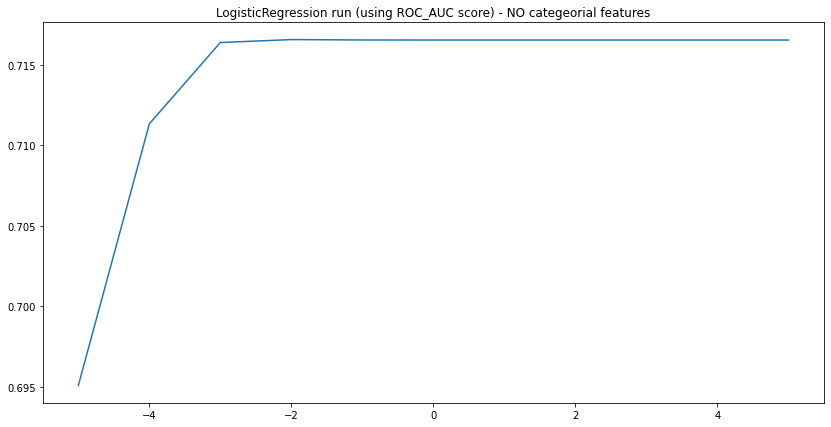

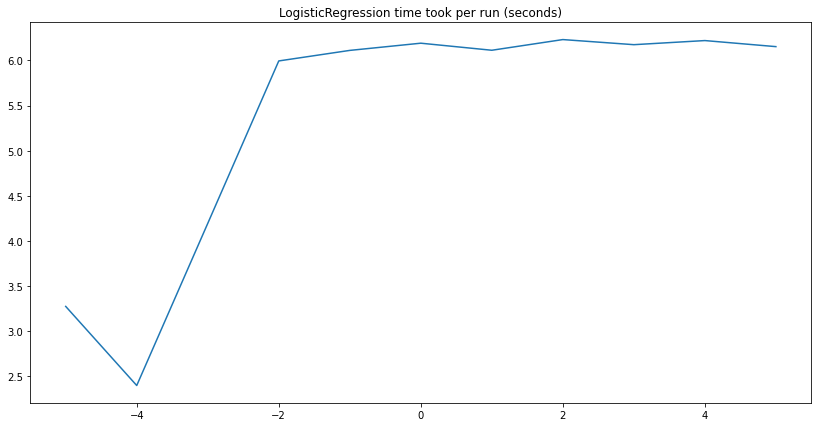

In [0]:
print_best_score(scores)
new_scores = pd.DataFrame([scores]).T
new_scores = new_scores.T.append(times,ignore_index=True)
new_scores.columns = np.arange(-5, 6)
plot_scores(new_scores.T.to_dict()[0], "LogisticRegression run (using ROC_AUC score) - NO categeorial features")
plot_scores(new_scores.T.to_dict()[1], "LogisticRegression time took per run (seconds)")

Качество и значение гипер-параметра С (0.7165592 при 0.01) такое же, как и при наличии категориальных признаков в тренировочной выборке. Модель LogisticRegression не отреагировала на удаление этих признаков - не смогла установить связь/извлечь пользу от их наличия.

##3. На предыдущем шаге мы исключили из выборки признаки rM_hero и dM_hero, которые показывают, какие именно герои играли за каждую команду.

Это важные признаки — герои имеют разные характеристики, и некоторые из них выигрывают чаще, чем другие. Выясните из данных, сколько различных идентификаторов героев существует в данной игре (вам может пригодиться фукнция unique или value_counts).

In [0]:
heroes_dataframe = data_train[hero_columns]
unique_heroes_values = np.unique(heroes_dataframe.values.ravel())
print(f"Количество уникальных героев в train датасете: {len(unique_heroes_values)}")
print(f"Количество различных идентификаторов героев в датасете: {max(unique_heroes_values)}")

Количество уникальных героев в train датасете: 108
Количество различных идентификаторов героев в датасете: 112


##4. Воспользуемся подходом "мешок слов" для кодирования информации о героях.

Пусть всего в игре имеет N различных героев. Сформируем N признаков, при этом i-й будет равен нулю, если i-й герой не участвовал в матче; единице, если i-й герой играл за команду Radiant; минус единице, если i-й герой играл за команду Dire. Добавьте полученные признаки к числовым, которые вы использовали во втором пункте данного этапа.

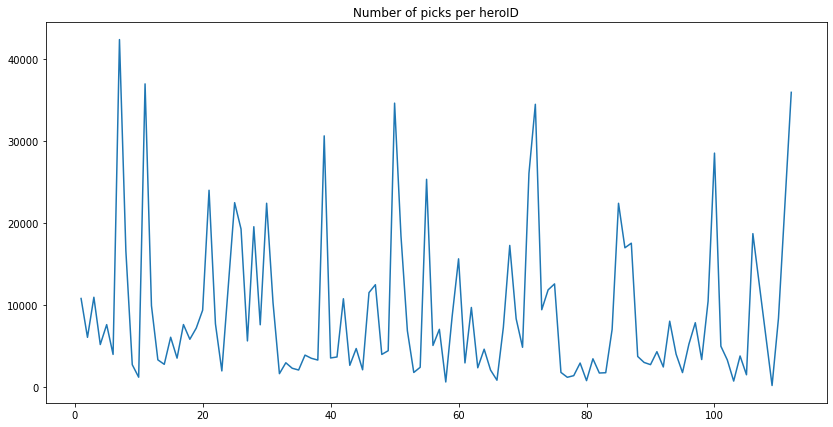

In [0]:
# top picked heroes IDs
heroes_picked_count = pd.value_counts(heroes_dataframe.values.ravel()).T
plot_scores(heroes_picked_count.sort_index(), "Number of picks per heroID")

In [0]:
print(hero_columns)

['r1_hero', 'r2_hero', 'r3_hero', 'r4_hero', 'r5_hero', 'd1_hero', 'd2_hero', 'd3_hero', 'd4_hero', 'd5_hero']


In [0]:
def get_heroes_picked_feature(data):
    hero_columns = [f"{type}{number}_hero" for type in 'rd' for number in range(1, 6)]
    heroes_dataframe = data[hero_columns]
    unique_heroes_ids = set(heroes_dataframe.values.ravel())
    X_heroes_picked = pd.DataFrame(np.zeros((data.shape[0], max(unique_heroes_ids) + 1)))  # .iloc[:,1:]
    X_heroes_picked.index = data.index
    for hero_id in unique_heroes_ids:
        for hero_type in hero_columns:
            idx_toupdate = heroes_dataframe[heroes_dataframe[hero_type]==hero_id].index
            X_heroes_picked.loc[idx_toupdate, hero_id] = -1 if 'd' in hero_type else 1
    return X_heroes_picked

In [0]:
# some explorational analysis
# most preferred heroes by radiant and dire by hero_id
# value > 0 - radiant team picks most often
# value < 0 - dire team picks this hero most often
# plot_scores(X_heroes_picked.sum(), "Most preferred heroes between radiant and dire by hero_id")

In [0]:
# X_heroes_picked.where(X_heroes_picked == 0).count()
# most not picked heroes
X_train.head()

,start_time,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,r1_items,r2_level,r2_xp,r2_gold,r2_lh,r2_kills,r2_deaths,r2_items,r3_level,r3_xp,r3_gold,r3_lh,r3_kills,r3_deaths,r3_items,r4_level,r4_xp,r4_gold,r4_lh,r4_kills,r4_deaths,r4_items,r5_level,r5_xp,r5_gold,r5_lh,r5_kills,r5_deaths,r5_items,d1_level,d1_xp,d1_gold,d1_lh,...,d3_xp,d3_gold,d3_lh,d3_kills,d3_deaths,d3_items,d4_level,d4_xp,d4_gold,d4_lh,d4_kills,d4_deaths,d4_items,d5_level,d5_xp,d5_gold,d5_lh,d5_kills,d5_deaths,d5_items,first_blood_time,first_blood_team,first_blood_player1,first_blood_player2,radiant_bottle_time,radiant_courier_time,radiant_flying_courier_time,radiant_tpscroll_count,radiant_boots_count,radiant_ward_observer_count,radiant_ward_sentry_count,radiant_first_ward_time,dire_bottle_time,dire_courier_time,dire_flying_courier_time,dire_tpscroll_count,dire_boots_count,dire_ward_observer_count,dire_ward_sentry_count,dire_first_ward_time
match_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,-2.544364,1.400808,1.525972,0.734957,0.969743,-0.537757,-0.578083,-0.509023,-0.332256,-0.625222,-0.255162,-0.052580,-0.533149,-0.582396,-1.756715,1.50723,1.308568,0.095346,-0.037204,-0.529081,-0.578154,-0.112095,-0.282744,-0.729830,-0.757388,-0.446505,-0.525343,-0.579877,-0.525183,-0.277630,-0.771379,-0.935772,-0.669994,-0.524078,1.052453,1.115474,-0.417344,-0.322641,-0.337650,0.082842,...,1.558823,0.961587,1.416964,-0.538253,-0.571065,-0.947053,-0.311205,-0.785580,-1.312874,-0.905651,-0.53886,-0.56754,-0.131690,-0.316231,-0.398260,-0.192406,-0.794164,0.976866,-0.565289,0.278256,-0.849902,1.182703,1.681514,-0.788219,0.378538,-0.029781,0.876751,-0.514555,-1.136970,-0.532046,-0.987486,1.066448,-0.041743,-0.262922,0.640648,0.018054,0.562864,-0.551154,1.846004,-1.121494
1,-2.540452,0.501314,-0.080139,-0.247570,-0.246859,-0.537757,1.017574,1.492930,0.578881,0.732454,-0.250795,-0.052580,-0.533149,1.019572,-0.524101,0.59158,0.582307,0.884835,0.856569,1.014674,-0.578154,-0.521910,-0.282744,-0.889558,-1.001642,-0.334372,-0.525343,-0.579877,-0.525183,-1.190175,-1.344598,-1.198371,-1.005251,-0.524078,-0.573665,-1.352836,1.392776,1.286498,0.507465,0.526938,...,-0.859912,0.548265,-0.942193,2.506742,-0.571065,1.517711,-1.232681,-1.337375,-1.127777,-1.131068,-0.53886,-0.56754,-0.543653,0.599652,0.531154,1.183531,1.570177,-0.540155,-0.565289,0.278256,-0.287631,1.182703,1.050584,-0.788219,0.912215,-0.029781,-1.525446,-0.514555,-2.869460,-0.532046,-0.987486,-0.338591,0.578946,-0.262922,0.379585,1.066668,0.562864,0.678170,0.437788,0.043947
2,-2.539231,0.501314,0.151070,0.263085,1.190944,-0.537757,-0.578083,1.492930,-0.332256,0.224676,-0.726779,-0.498410,-0.533149,-0.582396,-0.934972,-0.32407,0.205660,-0.419251,-1.154419,1.014674,-0.578154,-0.931725,1.547927,2.179771,2.251377,1.796163,1.030097,1.043031,-0.937075,-0.277630,0.427498,1.202532,1.900308,-0.524078,-0.573665,0.292704,1.392776,1.901968,1.910183,0.860010,...,-0.796356,-1.073911,-0.829853,-0.538253,-0.571065,-0.125465,0.610270,0.268676,-0.940451,-0.680234,-0.53886,-0.56754,-0.543653,-0.316231,0.313323,0.939019,1.682765,-0.540155,-0.565289,-0.543829,1.746117,-0.845521,-0.211277,-0.788219,-0.593027,-0.146503,-1.525446,-0.514555,1.461765,-0.532046,0.391203,-0.823968,-0.824352,0.158654,0.640648,0.018054,0.562864,0.678170,0.437788,0.490286
3,-2.532622,0.501314,0.962950,-0.198013,0.306142,-0.537757,-0.578083,-1.309804,-1.243393,-1.170813,-1.242065,-1.055698,-0.533149,-0.582396,-0.934972,1.50723,1.539241,0.086550,0.521404,-0.529081,-0.578154,-0.931725,-1.198079,-1.031136,-1.294746,-1.119305,-0.525343,-0.579877,-0.937075,-0.277630,-0.807544,-0.015573,0.224024,-0.524078,-0.573665,-0.941451,1.392776,1.140213,0.050057,0.637962,...,0.885136,-0.116160,0.068874,-0.538253,-0.571065,-0.536259,-1.232681,-0.909825,-1.230361,-1.018359,-0.53886,-0.56754,-0.543653,-1.232114,-1.211497,-1.312717,-1.131927,-0.540155,-0.565289,-0.543829,-0.933645,-0.845521,-1.157673,-0.788219,1.391156,0.262024,-1.525446,-1.549070,-0.270

In [0]:
X_train = pd.concat([X_train, get_heroes_picked_feature(data_train)], axis=1)
X_train.head()

,start_time,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,r1_items,r2_level,r2_xp,r2_gold,r2_lh,r2_kills,r2_deaths,r2_items,r3_level,r3_xp,r3_gold,r3_lh,r3_kills,r3_deaths,r3_items,r4_level,r4_xp,r4_gold,r4_lh,r4_kills,r4_deaths,r4_items,r5_level,r5_xp,r5_gold,r5_lh,r5_kills,r5_deaths,r5_items,d1_level,d1_xp,d1_gold,d1_lh,...,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112
match_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,-2.544364,1.400808,1.525972,0.734957,0.969743,-0.537757,-0.578083,-0.509023,-0.332256,-0.625222,-0.255162,-0.052580,-0.533149,-0.582396,-1.756715,1.50723,1.308568,0.095346,-0.037204,-0.529081,-0.578154,-0.112095,-0.282744,-0.729830,-0.757388,-0.446505,-0.525343,-0.579877,-0.525183,-0.277630,-0.771379,-0.935772,-0.669994,-0.524078,1.052453,1.115474,-0.417344,-0.322641,-0.337650,0.082842,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-2.540452,0.501314,-0.080139,-0.247570,-0.246859,-0.537757,1.017574,1.492930,0.578881,0.732454,-0.250795,-0.052580,-0.533149,1.019572,-0.524101,0.59158,0.582307,0.884835,0.856569,1.014674,-0.578154,-0.521910,-0.282744,-0.889558,-1.001642,-0.334372,-0.525343,-0.579877,-0.525183,-1.190175,-1.344598,-1.198371,-1.005251,-0.524078,-0.573665,-1.352836,1.392776,1.286498,0.507465,0.526938,...,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-2.539231,0.501314,0.151070,0.263085,1.190944,-0.537757,-0.578083,1.492930,-0.332256,0.224676,-0.726779,-0.498410,-0.533149,-0.582396,-0.934972,-0.32407,0.205660,-0.419251,-1.154419,1.014674,-0.578154,-0.931725,1.547927,2.179771,2.251377,1.796163,1.030097,1.043031,-0.937075,-0.277630,0.427498,1.202532,1.900308,-0.524078,-0.573665,0.292704,1.392776,1.901968,1.910183,0.860010,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-2.532622,0.501314,0.962950,-0.198013,0.306142,-0.537757,-0.578083,-1.309804,-1.243393,-1.170813,-1.242065,-1.055698,-0.533149,-0.582396,-0.934972,1.50723,1.539241,0.086550,0.521404,-0.529081,-0.578154,-0.931725,-1.198079,-1.031136,-1.294746,-1.119305,-0.525343,-0.579877,-0.937075,-0.277630,-0.807544,-0.015573,0.224024,-0.524078,-0.573665,-0.941451,1.392776,1.140213,0.050057,0.637962,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-2.529221,0.501314,0.348745,-0.124754,-0.357459,0.968527,-0.578083,-0.108632,-1.243393,-1.008757,-1.213680,-1.167155,-0.533149,1.019572,-0.524101,-0.32407,-0.538623,-0.379666,-1.154419,1.014674,-0.578154,-0.112095,-0.282744,-0.424893,0.792515,0.674829,1.030097,-0.579877,1.122386,0.634915,0.584817,-0.445882,-0.334737,-0.524078,-0.573665,-0.118681,-0.417344,-0.954166,-1.230685,-1.138424,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


##5. Проведите кросс-валидацию для логистической регрессии на новой выборке с подбором лучшего параметра регуляризации.

In [0]:
clf_params = {"random_state": 42, 'solver':'sag'}  # default: 'lbfgs' failed to converge for -1 power and above
# 'sag' - Stochastic Average Gradient descent - solver is faster for large datasets: https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
c_test_values = np.power(10.0, np.arange(-5, 6))
scores, times = get_train_cross_val_score_clf_parametric(LogisticRegression, cross_val_folds, "C", c_test_values, "roc_auc", **clf_params)

*************************************************************************************************************************************
pre-testing defined parameters were {'random_state': 42, 'solver': 'sag'}
hyper-tuning 'LogisticRegression' classifier using 'roc_auc' scoring function
parameter name to tune 'C', cycle through values: [1.e-05 1.e-04 1.e-03 1.e-02 1.e-01 1.e+00 1.e+01 1.e+02 1.e+03 1.e+04
 1.e+05]
*************************************************************************************************************************************
C = 1e-05 using roc_auc score is 0.6991712, this run took 13.13 seconds, done 1 of 11
C = 0.0001 using roc_auc score is 0.7250373, this run took 13.99 seconds, done 2 of 11
C = 0.001 using roc_auc score is 0.7463329, this run took 15.85 seconds, done 3 of 11
C = 0.01 using roc_auc score is 0.7517380, this run took 23.66 seconds, done 4 of 11
C = 0.1 using roc_auc score is 0.7519473, this run took 72.02 seconds, done 5 of 11
C = 1.0 using roc_auc 

Maximum value of 0.7519472549292117 reached with 0.1 value of the parameter


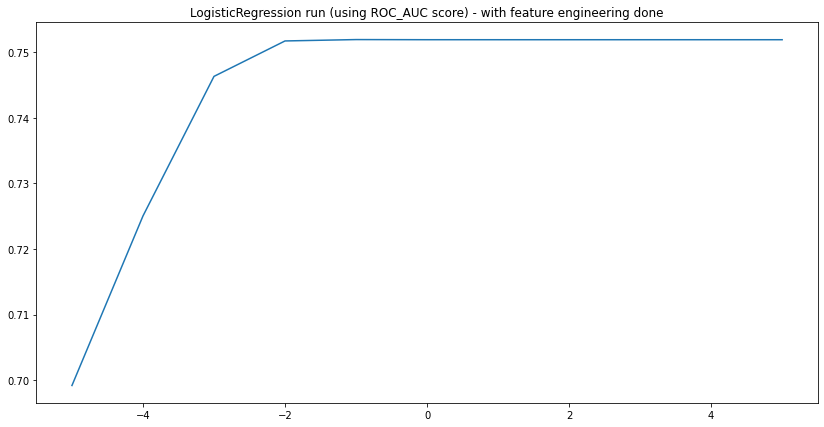

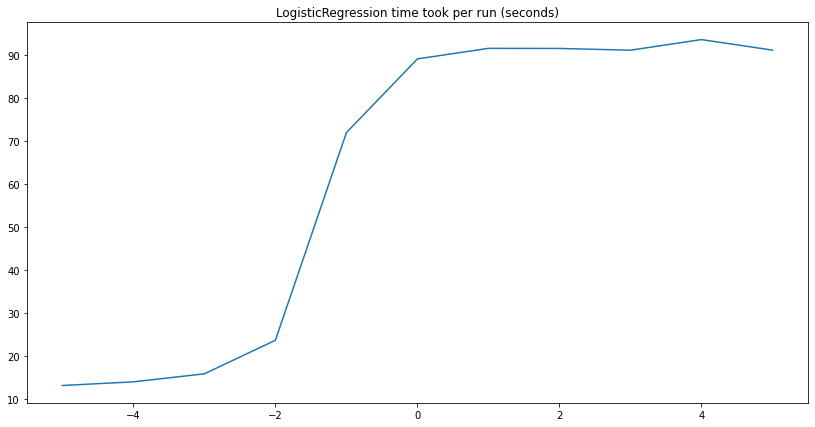

In [0]:
print_best_score(scores)
new_scores = pd.DataFrame([scores]).T
new_scores = new_scores.T.append(times,ignore_index=True)
new_scores.columns = np.arange(-5, 6)
plot_scores(new_scores.T.to_dict()[0], "LogisticRegression run (using ROC_AUC score) - with feature engineering done")
plot_scores(new_scores.T.to_dict()[1], "LogisticRegression time took per run (seconds)")

#####Какое получилось качество? Улучшилось ли оно? Чем вы можете это объяснить?



После добавления "мешка слов" качество улучшилось до 0.7519473. Видно улучшение качества - так как использованные герои во время битвы влияют на исход боя и в бинаризированном виде помогают модели установить зависимости.

##6. Постройте предсказания вероятностей победы команды Radiant для тестовой выборки с помощью лучшей из изученных моделей (лучшей с точки зрения AUC-ROC на кросс-валидации).

In [0]:
best_parameter_value = pd.Series(scores).idxmax()
best_model = LogisticRegression(C=0.1, random_state=42, solver='sag')
best_model.fit(X_train, y_train)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='sag', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
dataset_filepath = '/content/drive/My Drive/coursera/Week 7/week_7_features_test.zip'
test_data = pd.read_csv(dataset_filepath, index_col="match_id")
test_data.fillna(0, inplace=True)

In [0]:
#scaler = StandardScaler()
X_test = pd.DataFrame(data_scaler.transform(test_data), index=test_data.index, columns=test_data.columns)
categorial_columns = ["lobby_type"] +  [f"{type}{number}_hero" for type in 'rd' for number in range(1, 6)]
X_test.drop(categorial_columns, axis=1, inplace=True)
X_test = pd.concat([X_test, get_heroes_picked_feature(test_data)], axis=1)
X_test.head()

,start_time,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,r1_items,r2_level,r2_xp,r2_gold,r2_lh,r2_kills,r2_deaths,r2_items,r3_level,r3_xp,r3_gold,r3_lh,r3_kills,r3_deaths,r3_items,r4_level,r4_xp,r4_gold,r4_lh,r4_kills,r4_deaths,r4_items,r5_level,r5_xp,r5_gold,r5_lh,r5_kills,r5_deaths,r5_items,d1_level,d1_xp,d1_gold,d1_lh,...,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112
match_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
6,-2.528200,0.501314,-0.230161,-0.126909,-0.357459,-0.537757,1.017574,0.291758,-0.332256,-0.011207,-0.316298,-0.164037,-0.533149,2.621540,0.297642,1.50723,1.993380,2.074565,1.080012,2.558429,-0.578154,-0.931725,-0.282744,-0.439414,-0.168958,0.450562,-0.525343,-0.579877,-0.937075,-0.277630,0.335277,-0.328926,-0.781746,-0.524078,-0.573665,0.292704,-0.417344,-0.208467,-0.440022,-0.694327,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,-2.527214,-1.297676,-1.195592,-1.245180,-1.131661,-0.537757,-0.578083,0.291758,0.578881,0.008600,0.607286,1.173453,-0.533149,-0.582396,-0.524101,0.59158,0.344425,-0.078385,0.297961,-0.529081,1.039791,-0.112095,-1.198079,-0.698973,-0.766270,-1.119305,1.030097,-0.579877,-0.113291,1.547460,1.980794,1.555606,1.565051,-0.524078,-0.573665,-0.941451,-0.417344,-0.588452,-0.394282,0.526938,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,-2.525688,-1.297676,-0.851426,-0.732370,-1.131661,-0.537757,-0.578083,1.893320,-1.243393,-1.383288,-1.176562,-0.832783,-0.533149,-0.582396,-0.934972,-0.32407,-0.401660,-0.447840,-0.819255,1.014674,2.657736,-0.931725,1.547927,1.303079,0.952390,1.459763,-0.525343,-0.579877,-0.113291,0.634915,0.763834,1.127504,1.788555,-0.524078,-0.573665,-1.764221,-0.417344,-0.984493,-1.036831,-1.138424,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
13,-2.521671,-0.398181,-0.927319,-0.527677,-1.131661,0.968527,1.017574,1.092539,-1.243393,-0.931329,-0.451669,-0.498410,-0.533149,-0.582396,-0.113229,1.50723,1.726664,1.157527,1.973784,-0.529081,-0.578154,-0.521910,0.632591,0.762180,2.413473,2.020430,2.585536,-0.579877,-0.525183,1.547460,1.449165,1.293007,1.900308,-0.524078,-0.573665,-0.118681,0.487716,0.028801,-0.973665,-0.694327,...,0.0,1.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0
16,-2.520369,0.501314,0.045173,-1.049106,-0.799860,-0.537757,-0.578083,0.291758,1.490017,0.925122,-0.314114,-0.052580,-0.533149,1.019572,-0.934972,-0.32407,-0.151163,-0.346679,-0.930976,1.014674,-0.578154,-0.931725,-0.282744,0.228542,-0.153414,0.002029,-0.525343,-0.579877,-0.113291,-1.190175,-1.219828,-1.043901,-0.669994,-0.524078,-0.573665,-0.118681,0.487716,1.844881,1.152193,0.526938,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
y_preds = pd.Series(best_model.predict_proba(X_test)[:, 1])
y_preds.describe()

count    17177.000000
mean         0.517032
std          0.220954
min          0.008430
25%          0.346087
50%          0.522152
75%          0.691720
max          0.996372
dtype: float64

#####Какое минимальное и максимальное значение прогноза на тестовой выборке получилось у лучшего из алгоритмов?

Минимальное значение прогноза - 0.008430, максимальное - 0.996372.

In [0]:
y_preds.index

RangeIndex(start=0, stop=17177, step=1)

In [0]:
output = pd.DataFrame({'match_id': X_test.index,
                       'radiant_win': y_preds})
submission_filepath = '/content/drive/My Drive/coursera/Week 7/lin_reg_c_0.01.csv'
output.to_csv(submission_filepath, index=False)

In [0]:
# result: 0.75529